In [57]:
# (C) Copyright Aaron Goldberg, 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [1]:
# Implementing idea from https://doi.org/10.1103/PhysRevLett.128.160501. Let's use n=2, amplify a squeezed state, and vary the gain coefficient by varying the beam splitter transmissivity. Other n will take longer
import strawberryfields as sf
from strawberryfields.ops import Sgate, Rgate, BSgate, MeasureFock
from strawberryfields.tdm import borealis_gbs, full_compile, get_mode_indices
import numpy as np

2023-07-19 19:27:23.307331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# We repeatedly run everything below to see the predicted values both with and without noise
coeffs_predict_real=[[0.8051666432653461, 0.17238267030103366, 0.020475993431462565, 0.001827348014715966, 0.00013750765036067773, 9.232806285721881e-06, 5.712884320968008e-07, 3.3242363034724864e-08],
                     [0.5802204978087474, 0.30700735112746114, 0.08912888838335431, 0.01939330878006981, 0.003563254910785536, 0.0005852893885196724, 8.874041076913554e-05, 1.2669190293024409e-05],
                     [0.42267264749572314, 0.35328666111521345, 0.1552559533002008, 0.05045248853747779, 0.013906863003065395, 0.0034534953174345795, 0.0007974354558619722, 0.00017445577502290524],
                     [0.37202944649786224, 0.36612486894345847, 0.17699985926741782, 0.061029937479396175, 0.0177400765736194, 0.004660834181458196, 0.0011460121764057388, 0.00026896488038205633]
                    ]

Gain 0.5
1696.0
1852.0
2219.0
[0.77830189 0.18985849 0.02889151 0.00294811]
[4484. 1105.  163.   15.]
[0.77752731 0.19160742 0.02826426 0.00260101]
Gain 1.0
955.0
1062.0
1310.0
[0.55602094 0.3078534  0.0973822  0.03246073 0.0052356  0.00104712]
[1.892e+03 1.014e+03 3.130e+02 8.600e+01 1.700e+01 4.000e+00 1.000e+00]
[5.68680493e-01 3.04779080e-01 9.40787496e-02 2.58491133e-02
 5.10970845e-03 1.20228434e-03 3.00571085e-04]
Gain 2.0
336.0
439.0
415.0
[0.37202381 0.375      0.16071429 0.06547619 0.01785714 0.00892857]
[503. 415. 170.  68.  23.  10.   1.]
[0.42268908 0.3487395  0.14285714 0.05714286 0.01932773 0.00840336
 0.00084034]
Gain 4.0
128.0
273.0
202.0
[0.3828125 0.390625  0.15625   0.03125   0.0390625]
[232. 223. 100.  26.  17.   5.]
[0.38474295 0.36981758 0.16583748 0.04311774 0.02819237 0.00829187]


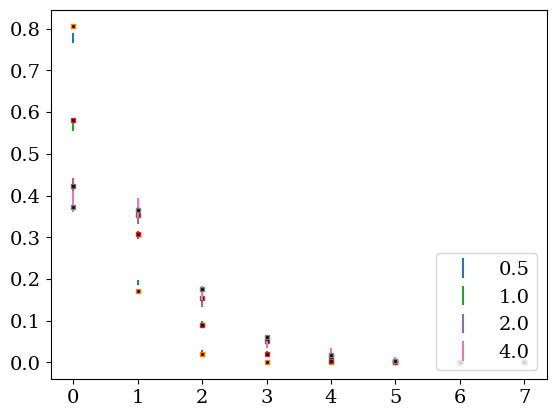

In [60]:
import matplotlib.pyplot as plt

fig = plt.figure()

certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze=certificate_from_expt["squeezing_parameters_mean"]["high"]

gains=[0.5, 1.0, 2.0, 4.0]
top_range=20
counter=0
# Depending on the gain, the pattern with the most successful postselections changes places (because more photons get lost in different places depending on the gain)
for gain in gains:
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_{squeeze}_v1.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_{squeeze}_v1.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    print(sum(list110))
    print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=np.array(list011)+np.array(list101)+np.array(list110)
    print(totals)
    x = np.arange(longest)
    y=totals/np.sum(totals)
    yerr=np.sqrt(totals)/np.sum(totals)
    print(y)
    plt.errorbar(x, y , yerr=yerr, label=f'{gain}',linestyle='')
    plt.plot(np.arange(len(coeffs_predict_real[counter])),coeffs_predict_real[counter],linestyle='',marker='s',markerfacecolor='black',markersize=3.)
    counter+=1
#plt.yscale('log')
plt.legend(loc='lower right')


Gain 0.5
[4484. 1105.  163.   15.    0.    0.    0.    0.]
Gain 0.5
[8.585e+03 2.150e+03 2.860e+02 2.800e+01 2.000e+00 0.000e+00 0.000e+00
 0.000e+00]
[7.76852774e-01 1.94552529e-01 2.58800109e-02 2.53370736e-03
 1.80979097e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.00838433 0.00419583 0.00153032 0.00047883 0.00012797 0.
 0.         0.        ]


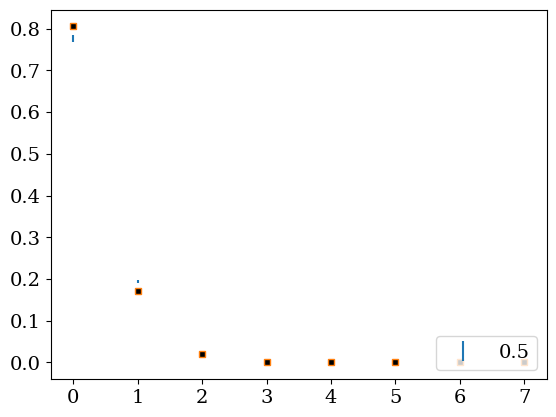

In [61]:
# Now let's try using v2 as well
fig = plt.figure()

certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze=certificate_from_expt["squeezing_parameters_mean"]["high"]

gains=[0.5]#, 1.0, 2.0, 4.0]
coeffs_predict_real_restricted=[[0.8051666432653461, 0.17238267030103366, 0.020475993431462565, 0.001827348014715966, 0.00013750765036067773, 9.232806285721881e-06, 5.712884320968008e-07, 3.3242363034724864e-08],
                                [0.5802204978087474, 0.30700735112746114, 0.08912888838335431, 0.01939330878006981, 0.003563254910785536, 0.0005852893885196724, 8.874041076913554e-05, 1.2669190293024409e-05],
                                [0.42267264749572314, 0.35328666111521345, 0.1552559533002008, 0.05045248853747779, 0.013906863003065395, 0.0034534953174345795, 0.0007974354558619722, 0.00017445577502290524],
                                [0.37202944649786224, 0.36612486894345847, 0.17699985926741782, 0.061029937479396175, 0.0177400765736194, 0.004660834181458196, 0.0011460121764057388, 0.00026896488038205633]
                    ]
top_range=20
counter=0
# Depending on the gain, the pattern with the most successful postselections changes places (because more photons get lost in different places depending on the gain)
for gain in gains:
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_{squeeze}_v1.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_{squeeze}_v1.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list110))
    #print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    longest=8
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=np.array(list011)+np.array(list101)+np.array(list110)
    print(totals)
    
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_v2.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_v2.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list110))
    #print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    longest=8
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=totals+np.array(list011)+np.array(list101)+np.array(list110) # This could be faulty if v2 had a different longest than v1
    print(totals)
    
    x = np.arange(longest)
    y=totals/np.sum(totals)
    yerr=np.sqrt(totals)/np.sum(totals)
    print(y)
    print(yerr)
    plt.errorbar(x, y , yerr=yerr, label=f'{gain}',linestyle='')
    plt.plot(np.arange(len(coeffs_predict_real_restricted[counter])),coeffs_predict_real_restricted[counter],linestyle='',marker='s',markerfacecolor='black',markersize=4.)
    counter+=1
#plt.yscale('log')
#plt.ylim([0.5,0.6])
plt.legend(loc='lower right')


Gain 0.5
[4484. 1105.  163.   15.    0.    0.    0.    0.]
Gain 0.5
[8986. 2235.  310.   30.    0.    0.    0.    0.]
Gain 0.5
[1.3519e+04 3.4390e+03 4.7900e+02 4.9000e+01 2.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
Gain 0.5
[1.7938e+04 4.4410e+03 6.3800e+02 6.4000e+01 3.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
total successful heralds: 23084.0 out of total counts 4000000.0
[7.77075030e-01 1.92384335e-01 2.76381910e-02 2.77248311e-03
 1.29960146e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[5.80197622e-03 2.88688392e-03 1.09420646e-03 3.46560388e-04
 7.50325250e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[5.90591721e-03 2.73269567e-03 9.41817938e-04 2.81355300e-04
 7.71805551e-05 1.99991404e-05 4.97476056e-06 1.20002532e-06]
Gain 1.0
[1.892e+03 1.014e+03 3.130e+02 8.600e+01 1.700e+01 4.000e+00 1.000e+00
 0.000e+00]
Gain 1.0
[3.614e+03 2.081e+03 6.200e+02 1.530e+02 3.300e+01 4.000e+00 1.000e+00
 0.000e+00]
Gain 1.0
[5.414e+03 3.002e+03 9.140e+02 2.260e+02 5.200e+01 6.000

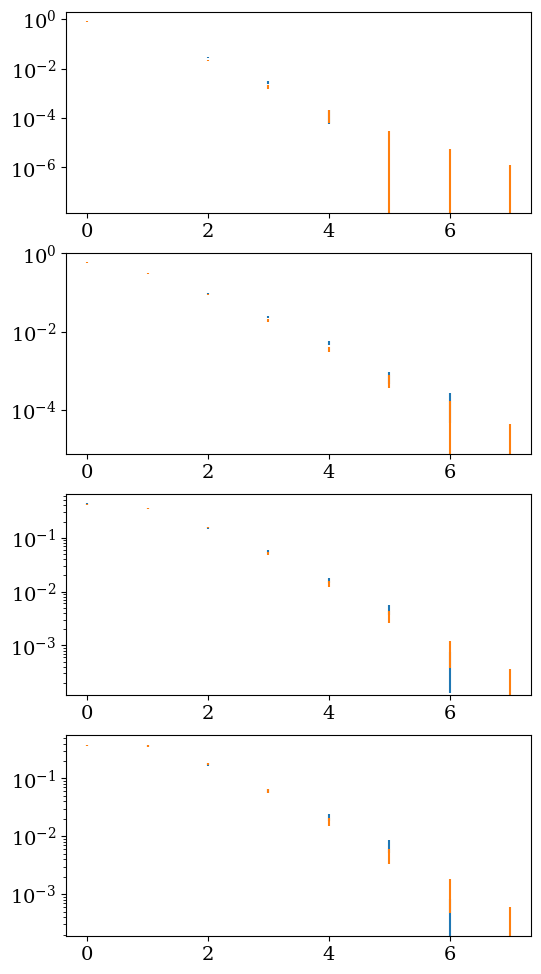

In [62]:
# Now let's try using v2-v4 as well
# Now let's try making the errors from what we think the counts should be, not just errors on our counts
fig, axs = plt.subplots(4, 1,figsize=(6, 12))

certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze=certificate_from_expt["squeezing_parameters_mean"]["high"]

gains=[0.5, 1.0, 2.0, 4.0]
coeffs_predict_real_restricted=[[0.8051666432653461, 0.17238267030103366, 0.020475993431462565, 0.001827348014715966, 0.00013750765036067773, 9.232806285721881e-06, 5.712884320968008e-07, 3.3242363034724864e-08],
                                [0.5802204978087474, 0.30700735112746114, 0.08912888838335431, 0.01939330878006981, 0.003563254910785536, 0.0005852893885196724, 8.874041076913554e-05, 1.2669190293024409e-05],
                                [0.42267264749572314, 0.35328666111521345, 0.1552559533002008, 0.05045248853747779, 0.013906863003065395, 0.0034534953174345795, 0.0007974354558619722, 0.00017445577502290524],
                                [0.37202944649786224, 0.36612486894345847, 0.17699985926741782, 0.061029937479396175, 0.0177400765736194, 0.004660834181458196, 0.0011460121764057388, 0.00026896488038205633]
                    ]
top_range=20
counter=0
# Depending on the gain, the pattern with the most successful postselections changes places (because more photons get lost in different places depending on the gain)
for gain in gains:
    total_counts=0
    
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_{squeeze}_v1.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_{squeeze}_v1.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list110))
    #print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    longest=8
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=np.array(list011)+np.array(list101)+np.array(list110)
    print(totals)
    total_counts=total_counts+np.sum(counts)
    
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_{squeeze}_v2.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_{squeeze}_v2.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list110))
    #print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    longest=8
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=totals+np.array(list011)+np.array(list101)+np.array(list110) # This could be faulty if v2 had a different longest than v1
    print(totals)
    total_counts=total_counts+np.sum(counts)
    
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_{squeeze}_v3.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_{squeeze}_v3.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list110))
    #print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    longest=8
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=totals+np.array(list011)+np.array(list101)+np.array(list110) # This could be faulty if v2 had a different longest than v1
    print(totals)
    total_counts=total_counts+np.sum(counts)
    
    unique = np.loadtxt(f'Borealis_teleamp_patterns_{gain}_{squeeze}_v4.csv',  delimiter=',')
    counts = np.loadtxt(f'Borealis_teleamp_counts_{gain}_{squeeze}_v4.csv', delimiter=',')
    print('Gain',gain)
    my_list = [counts[np.where((unique == (2, i, 0, 1, 1)).all(axis=1))[0]] for i in range(top_range)]
    list011 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list011))
    my_list = [counts[np.where((unique == (2, i, 1, 0, 1)).all(axis=1))[0]] for i in range(top_range)]
    list101 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list101))
    my_list = [counts[np.where((unique == (2, i, 1, 1, 0)).all(axis=1))[0]] for i in range(top_range)]
    list110 = [x[0] for x in my_list if x.size > 0] # this one works!
    #print(sum(list110))
    #print(np.array(list011)/np.sum(list011))
    
    # Naive method for making lengths equal
    longest=max([len(list011),len(list101),len(list110)])
    longest=8
    padding=[0 for i in range(longest)]
    list011=list011+padding
    list011=list011[0:longest]
    list101=list101+padding
    list101=list101[0:longest]
    list110=list110+padding
    list110=list110[0:longest]
    totals=totals+np.array(list011)+np.array(list101)+np.array(list110) # This could be faulty if v2 had a different longest than v1
    print(totals)
    total_counts=total_counts+np.sum(counts)
    print('total successful heralds:',np.sum(totals),'out of total counts',total_counts)
    
    x = np.arange(longest)
    y=totals/np.sum(totals)
    yerr=np.sqrt(totals)/np.sum(totals)
    print(y)
    print(yerr)
    axs[counter].errorbar(x, y , yerr=yerr, label=f'{gain}',linestyle='')
    yerr=np.sqrt(coeffs_predict_real_restricted[counter])/np.sqrt(np.sum(totals))
    print(yerr)
    axs[counter].errorbar(np.arange(len(coeffs_predict_real_restricted[counter])),coeffs_predict_real_restricted[counter] , yerr=yerr, label=f'{gain}',linestyle='')
    #plt.plot(np.arange(len(coeffs_predict_real_restricted[counter])),coeffs_predict_real_restricted[counter],linestyle='',marker='s',markerfacecolor='black',markersize=4.)
    axs[counter].set_yscale('log')
    counter+=1
#plt.yscale('log')
#plt.ylim([0.5,0.6])
#plt.legend(loc='lower right')


In [63]:
# Compilation used make sure the specs match an actual device, so must be done using a particular device and its characteristics
# eng = sf.RemoteEngine("borealis")
# device = eng.device
# We can no longer compile automatically because the device is retired, so we must do it manually

In [2]:
# This time we will want to compile manually, because the device certificate today may be different from when the experiment was conducted
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
print(certificate_from_expt) # Tells us the loss parameters, squeezing parameters. The best detector seems to always be the 12th, ie index 11
print('The 12th detector has efficiency: ',certificate_from_expt['relative_channel_efficiencies'][11])

# What if we make losses better, manually?
deviation_improvement_factor=0.999 # If the current value is 1-eta, we add eta*factor to it to make it closer to a transmission of 1. 
certificate_from_expt['common_efficiency']=deviation_improvement_factor+np.array(certificate_from_expt['common_efficiency'])*(1.-deviation_improvement_factor)
certificate_from_expt['loop_efficiencies']=(deviation_improvement_factor+np.array(certificate_from_expt['loop_efficiencies'])*(1.-deviation_improvement_factor)).tolist()
certificate_from_expt['relative_channel_efficiencies']=(deviation_improvement_factor+np.array(certificate_from_expt['relative_channel_efficiencies'])*(1.-deviation_improvement_factor)).tolist()

print(certificate_from_expt)

{'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
The 12th detector has efficiency:  0.998
{'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.999386, 'loop_efficiencies': [0.99988, 0.999879, 0.999793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.999918, 0.999938, 0.999912, 1.0, 0.999961, 0.999917, 0.999893, 0.999969, 0.999951, 0.999955, 0.999965, 0.999998, 0.999947, 0.999966, 0.999947, 0.999898]}


In [65]:
def sim_circuit(my_gain, improve_factor, cutoff_val):
    # This time we will want to compile manually, because the device certificate today may be different from when the experiment was conducted
    certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}

    # What if we make losses better, manually?
    deviation_improvement_factor=improve_factor # If the current value is 1-eta, we add eta*factor to it to make it closer to a transmission of 1. 
    certificate_from_expt['common_efficiency']=deviation_improvement_factor+np.array(certificate_from_expt['common_efficiency'])*(1.-deviation_improvement_factor)
    certificate_from_expt['loop_efficiencies']=(deviation_improvement_factor+np.array(certificate_from_expt['loop_efficiencies'])*(1.-deviation_improvement_factor)).tolist()
    certificate_from_expt['relative_channel_efficiencies']=(deviation_improvement_factor+np.array(certificate_from_expt['relative_channel_efficiencies'])*(1.-deviation_improvement_factor)).tolist()


    # Let's define our circuit manually
    modes = 22 
    starting_mode = 0 # This can be modified if we are aiming for some particular detectors that are better than the rest)

    squeeze_level = "high"

    # squeezing-gate parameters. These will be rounded to the closest one supported by hardware
    r = [0.] * modes

    # rotation-gate parameters. These phases will not matter for the photon counting multiplexing we are doing here
    phi_0 = [0.] * modes
    phi_1 = [0.] * modes
    phi_2 = [0.] * modes


    # beamsplitter parameters. Set irrelevant transmission parameters to 1 to load all loops
    T_0 = [1.] * modes
    T_1 = [1.] * modes
    T_2 = [1.] * modes


    # Create a two-mode squeezed vacuum in the first two modes by interfering two single-mode squeezed vacuum states
    r[0+starting_mode] = certificate_from_expt["squeezing_parameters_mean"][squeeze_level] 
    r[1+starting_mode] = certificate_from_expt["squeezing_parameters_mean"][squeeze_level]

    # symmetric BS will convert two SV into one TMSV
    T_0[1+starting_mode] = 0.5 


    # Will postselect mode 0 to be in state |n> to herald mode 1 as starting in state |n>

    # Create a state to be amplified; here it's a single-mode squeezed vacuum
    r[2+starting_mode] = certificate_from_expt["squeezing_parameters_mean"][squeeze_level]
    # Delay the state psi in mode 2 to be amplified (all of the squeezed states needed to be in the first modes)
    T_0[2+starting_mode] = 1.
    delay_length = 11
    T_0[2+starting_mode+1:2+starting_mode+1+delay_length] = [0. for i in range(delay_length)]
    T_0[2+starting_mode+1+delay_length+1] = 1. # Just to make sure it gets out


    # Fixing phases
    #phi_0[8]= np.pi/2
    #phi_1[1] = np.pi
    phi_0[1+starting_mode+1:2+starting_mode+1+delay_length] = [-np.pi/2 for i in range(delay_length+1)] # The delays add phases too, even though they're just identity transformations



    # Amplification starts by a variable-transmissivity beam splitter between a vacuum state in mode 7 and the state |n> in mode 1. Will measure mode 1 as amplified state
    gain = my_gain
    tau = (1./gain)**2/(1.+(1./gain)**2)
    tau = 1./(1.+gain**2)
    print("tau is", tau)
    # We actually want the mode 1 to house the amplified state, which requires an extra swap relative to the paper
    # So we adjust the BS accordingly. This does a1-> sqrt(1-tau)a1-sqrt(tau)a2
    phi_1[1+starting_mode] += np.pi/2 # To fix the default phases from the beam splitter
    T_1[7+starting_mode] = 1.-tau 
    phi_2[1+starting_mode] += -np.pi/2 # To fix the default phases from the beam splitter



    # Next do QFT on modes 7, 2 delayed to 13, and 14. Then postselect on pattern 0,1,1 to get amplified state, but also will get the same state with different phases if postselect on 1,1,0 or 1,0,1, so that's good too.
    # The first BS does a13 -> sqrt(1/2)a13-sqrt(1/2)a14. Our phase choice will end up just adding a global phase
    T_0[14+starting_mode] = 0.5
    phi_0[2+starting_mode] += -np.pi/2 # Fix the phase. Since this must happen before going into the loop, that happened way back in time bin 2, which then remained in the loop for a long time
    phi_1[13+starting_mode] += np.pi/2 # Fix phase after exiting loop.

    phi_1[7]+=np.pi
    #phi_1[13]+=np.pi/2
    #phi_0[2+starting_mode] += np.pi/2


    # Now delay mode 14 an appropriate length so that it can intefere at the second loop
    delay_length2 = 5
    T_0[14+starting_mode+1:14+starting_mode+1+delay_length2] = [0. for i in range(delay_length2)]
    T_0[14+starting_mode+1+delay_length2+1] = 1. # Just to make sure it gets out
    phi_0[14+starting_mode+1:14+starting_mode+1+delay_length2] = [-np.pi/2 for i in range(delay_length2)]
    phi_1[19]+=-np.pi/2

    phi_0[2]+=-np.pi/2
    phi_0[8]+=-np.pi/2
    phi_0[14]+=-np.pi/2
    phi_2[7]+=np.pi/2
    phi_2[13]+=np.pi/2
    phi_2[19]+=-np.pi/2
    # Beam splitter between modes 7 and 13 at second loop
    phi_1[7+starting_mode] += np.pi/2 
    T_1[13+starting_mode] = 1./3  ### this one is not affecting anything yet
    phi_2[7+starting_mode] += -np.pi/2

    # Put phase on mode 14 that is now in mode 19
    phi_1[19]+=np.pi*3./2.




    # BS between modes 13 and 19 at second loop
    phi_1[19+starting_mode] += np.pi/2 # This will cancel with the one from before, anyway 
    T_1[19+starting_mode] = 0.5
    phi_2[19+starting_mode] += -np.pi/2

    # Finally, postselect on mode 19 having a 1, mode 13 having a 1, mode 7 having a 0. Already said to postselect on n=2 in mode 0. 
    # amplified state is in mode 1, so we will look at the (conditional) photon-number distribution there



    alpha_0 = np.arccos(np.sqrt(T_0))
    alpha_1 = np.arccos(np.sqrt(T_1))
    alpha_2 = np.arccos(np.sqrt(T_2))

    # the travel time per delay line in time bins
    delay_0, delay_1, delay_2 = 1, 6, 36

    # set the first beamsplitter arguments to 'T=1' ('alpha=0') to fill the
    # loops with pulses
    alpha_0[:delay_0] = 0.0
    alpha_1[:delay_1] = 0.0
    alpha_2[:delay_2] = 0.0

    #convert back to being lists so we can extend them
    alpha_0=alpha_0.tolist()
    alpha_1=alpha_1.tolist()
    alpha_2=alpha_2.tolist()

    ### Manual steps for compilation
    # second loop needs to await the first mode for 1 time bin (delay_0 = 1)
    phi_1 = [0] * delay_0 + phi_1
    alpha_1 = [0] * delay_0 + alpha_1
    # print(alpha_1)

    # second loop needs to await the first mode for 7 time bins (delay_0 + delay_1 = 1 + 6)
    phi_2 = [0] * (delay_0 + delay_1) + phi_2
    alpha_2 = [0] * (delay_0 + delay_1) + alpha_2

    # empty first loop (delay_0) and await the emptying of second and third loop
    # (delay_1 + delay_2)
    r += [0] * (delay_0 + delay_1 + delay_2)
    phi_0 += [0] * (delay_0 + delay_1 + delay_2)
    alpha_0 += [0] * (delay_0 + delay_1 + delay_2)

    # empty second loop (delay_1) and await the emptying of third loop (delay_2)
    phi_1 += [0] * (delay_1 + delay_2)
    alpha_1 += [0] * (delay_1 + delay_2)

    # empty third loop
    phi_2 += [0] * delay_2
    alpha_2 += [0] * delay_2

    gate_args_list = [r, phi_0, alpha_0, phi_1, alpha_1, phi_2, alpha_2]



    # the intrinsic roundtrip phase of each delay line
    phis_loop = certificate_from_expt["loop_phases"]

    # # Verify components if desired
    # print(gate_args_list[0])
    # #gate_args_list[0][0:modes]=r
    # #print(gate_args_list[0])

    delays = [1, 6, 36]
    vac_modes = sum(delays)

    n, N = get_mode_indices(delays)
    # print(vac_modes)
    # print(n,N)

    # Use this if want to manually add realistic losses gleaned from the device characteristics, can then be tweaked
    eta_glob = certificate_from_expt["common_efficiency"]
    etas_loop = certificate_from_expt["loop_efficiencies"]
    etas_ch_rel = certificate_from_expt["relative_channel_efficiencies"]

    prog_length = len(gate_args_list[0])
    reps = int(np.ceil(prog_length / 16))
    etas_ch_rel = np.tile(etas_ch_rel, reps)[:prog_length]
    etas_ch_rel = etas_ch_rel.tolist()

    gate_args_list += [etas_ch_rel]

    from strawberryfields.ops import LossChannel
    print("minimum loss for any mode is: ", 1-eta_glob)

    from strawberryfields.ops import LossChannel

    prog = sf.TDMProgram(N)

    with prog.context(*gate_args_list) as (p, q):
        Sgate(p[0]) | q[n[0]]
        LossChannel(eta_glob) | q[n[0]]
        for i in range(len(delays)):
            Rgate(p[2 * i + 1]) | q[n[i]]
            BSgate(p[2 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
            #Rgate(phis_loop[i]) | q[n[i]]
            LossChannel(etas_loop[i]) | q[n[i]]
        LossChannel(p[7]) | q[0]
        MeasureFock() | q[0]



    eng_sim = sf.Engine(backend="gaussian")
    results_sim = eng_sim.run(prog, shots=None, space_unroll=True, crop=True) # Using manual loss from specific device

    state = results_sim.state

    # reduced_state=state.reduced_gaussian([0,1,7,13,19])
    # from thewalrus.quantum import state_vector, density_matrix
    # mu0=reduced_state[0]
    # cov0=reduced_state[1]
    low_cutoff=3
    # rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)


    # Finally, postselect on mode 19 having a 1, mode 13 having a 1, mode 7 having a 0. Already said to postselect on n=2 in mode 0. 
    # amplified state is in mode 1, so we will look at the (conditional) photon-number distribution there
    max_photon_out = low_cutoff
    high_cutoff=cutoff_val
    extra=5
    amplified_probs = [0. for i in range(max_photon_out+extra)]
    for j in range(max_photon_out+extra):
        locations = [2,j,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
        amplified_probs[j] = state.fock_prob(locations[0:modes],cutoff=high_cutoff) 
        locations = [2,j,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
        amplified_probs[j] += state.fock_prob(locations[0:modes],cutoff=high_cutoff) 
        locations = [2,j,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
        amplified_probs[j] += state.fock_prob(locations[0:modes],cutoff=high_cutoff) 
    # # Can use any of the options 011, 110, 101 for the modes 7,13,19 since we aren't measuring the phase
    # amplified_probs1 = [0. for i in range(max_photon_out)]
    # for j in range(max_photon_out):
    #     amplified_probs1[j] = rho0[2,2,j,j,0,0,1,1,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
    # amplified_probs2 = [0. for i in range(max_photon_out)]
    # for j in range(max_photon_out):
    #     amplified_probs2[j] = rho0[2,2,j,j,1,1,1,1,0,0] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
    # amplified_probs3 = [0. for i in range(max_photon_out)]
    # for j in range(max_photon_out):
    #     amplified_probs3[j] = rho0[2,2,j,j,1,1,0,0,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
    # print(amplified_probs)
    # print(amplified_probs1)
    # print(amplified_probs2)
    # print(amplified_probs3)

    # print("Average from all three runs ",(amplified_probs/np.sum(amplified_probs)).tolist())
    # print((amplified_probs1/np.sum(amplified_probs1)).round(8)) # Same results approximately for each pattern, even with realistic losses
    # print((amplified_probs2/np.sum(amplified_probs2)).round(8)) 
    # print((amplified_probs3/np.sum(amplified_probs3)).round(8)) 

    # expected_probs = [gain**(2*2*i) *np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(2*i)*np.math.factorial(2*i)
    #                   /2**(2*i)/np.math.factorial(i)**2/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level]) 
    #                   for i in range(2)]
    # expected_probs=expected_probs/np.sum(expected_probs)
    # print("coefficients squared of 0 and 2 expected to be",expected_probs)
    # print("coefficients squared of 0 and 2 expected to be",[1, np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**2 * gain**(4)/2]/np.sum([1, np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**2 * gain**4/2]))
    # print("original coefficients of 0 and 2 proportional to",[1, np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])*np.sqrt(2.)/2])
    return (amplified_probs/np.sum(amplified_probs)).tolist()

In [66]:
# Let's run predictions with different noise improvement factors and different gains
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze_level="high"
cutoff_val=15
gains=[0.5, 1.0, 2.0, 4.0]
noise_factors=[ 0.999, 0.99, 0.9, 0.5, 0.1, 0.]
#starting with g=2. These are the measured photon number distributions and their errors
y=[0.42414929, 0.34555434 ,0.15367728, 0.05554336, 0.01602634 ,0.00461032,
 0.00043908, 0.        ]
yerr=[0.00963292, 0.00880683, 0.00583821, 0.00332811, 0.00174731, 0.00087073,
 0.00041841, 0.0001957 ]
coeffs_predict_real_restricted=[sim_circuit(gains[2],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)

tau is 0.2
minimum loss for any mode is:  0.0006140000000000034
tau is 0.2
minimum loss for any mode is:  0.006140000000000034
tau is 0.2
minimum loss for any mode is:  0.06140000000000001
tau is 0.2
minimum loss for any mode is:  0.30699999999999994
tau is 0.2
minimum loss for any mode is:  0.5526
tau is 0.2
minimum loss for any mode is:  0.614
[[0.15744304980319465, 0.004473838033550176, 0.8367375552402261, 0.0013441123516631617, 1.443275433903691e-06, 1.294882613277849e-09, 1.0487120491215124e-12, 8.045938595768874e-16], [0.15532484906168073, 0.04265901789416587, 0.7893706389577027, 0.01251172876458216, 0.00013258199707835212, 1.1738762720130695e-06, 9.3784084771649e-09, 7.010971220745005e-11], [0.15015480488709365, 0.2720321688043766, 0.5020701220612833, 0.06879541717141373, 0.006408725122588425, 0.0005010111732086758, 3.540705561425321e-05, 2.3437244212944626e-06], [0.24730010709395492, 0.3892054962325892, 0.24706129318487838, 0.08594482729771888, 0.023412424383629716, 0.005590569

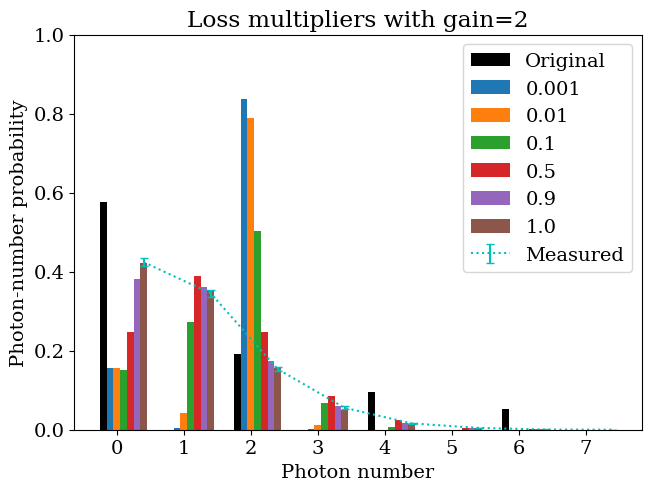

In [67]:
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(len(coeffs_predict_real_restricted[0]))]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=2')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain2.eps')

tau is 0.058823529411764705
minimum loss for any mode is:  0.0006140000000000034
tau is 0.058823529411764705
minimum loss for any mode is:  0.006140000000000034
tau is 0.058823529411764705
minimum loss for any mode is:  0.06140000000000001
tau is 0.058823529411764705
minimum loss for any mode is:  0.30699999999999994
tau is 0.058823529411764705
minimum loss for any mode is:  0.5526
tau is 0.058823529411764705
minimum loss for any mode is:  0.614
[[0.011569992230031355, 0.0028925373362898438, 0.9836761182472236, 0.0018590012933669146, 2.348411954583055e-06, 2.4787703895805247e-09, 2.3615236677061345e-12, 2.0736294188228387e-15], [0.011763998786653506, 0.027919450491283474, 0.942518917154048, 0.017576220519668274, 0.00021910919410364843, 2.282216130192887e-06, 2.1449481145636023e-08, 1.8863186080725284e-10], [0.025392795490833973, 0.19970757692197588, 0.656049150545897, 0.10610109774342712, 0.011593802998679832, 0.001061094574931929, 8.76979666605056e-05, 6.783757593744992e-06], [0.15718

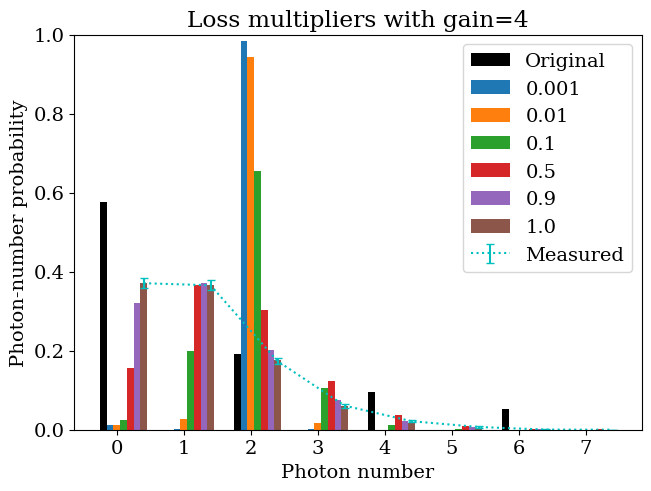

In [68]:
# Now do gain=4
coeffs_predict_real_restricted=[sim_circuit(gains[3],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[0.37088247, 0.36559577, 0.17364782, 0.06100041, 0.02155348, 0.00691338,
 0.00040667, 0.        ]
yerr=[0.01230012, 0.01220212, 0.00848413, 0.00498187, 0.00268595, 0.00137674,
 0.00068268, 0.00033073]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(len(coeffs_predict_real_restricted[0]))]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=4')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain4.eps')

tau is 0.5
minimum loss for any mode is:  0.0006140000000000034
tau is 0.5
minimum loss for any mode is:  0.006140000000000034
tau is 0.5
minimum loss for any mode is:  0.06140000000000001
tau is 0.5
minimum loss for any mode is:  0.30699999999999994
tau is 0.5
minimum loss for any mode is:  0.5526
tau is 0.5
minimum loss for any mode is:  0.614
[[0.7467865484527633, 0.004904610381144303, 0.24805962663394787, 0.00024904730002193234, 1.6713835405620274e-07, 9.372129221695302e-11, 4.737553286429699e-14, 2.366795592713596e-17], [0.7215974134933593, 0.04618795612468789, 0.22992206166034398, 0.002277399674841738, 1.508513106989083e-05, 8.349670309523042e-08, 4.17044865564973e-10, 1.949201886994173e-12], [0.5610774761729305, 0.2749715648405548, 0.15039336057825023, 0.01276587909770482, 0.0007524761693961079, 3.747767595661652e-05, 1.6936045130659857e-06, 7.18606939771422e-08], [0.4725169847625939, 0.36438578694037593, 0.1280148964216082, 0.02884254463819997, 0.005253421814661159, 0.000844207

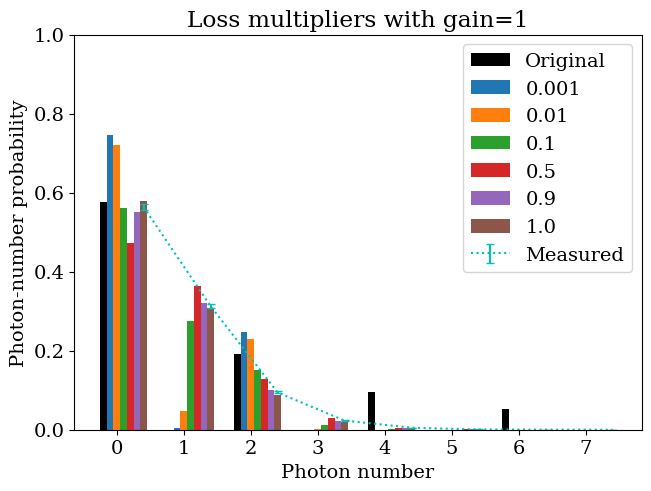

In [69]:
# Now do gain=1
coeffs_predict_real_restricted=[sim_circuit(gains[1],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[5.63767322e-01, 3.12769122e-01, 9.43396226e-02, 2.31738824e-02,
 5.08885931e-03, 7.04611289e-04, 1.56580287e-04, 0.00000000e+00]
yerr=[6.73984762e-03, 4.90261660e-03, 2.64157405e-03, 1.23219516e-03,
 5.28173965e-04, 2.14061650e-04, 8.33516615e-05, 3.14940109e-05]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(len(coeffs_predict_real_restricted[0]))]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=1')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain1.eps')

tau is 0.8
minimum loss for any mode is:  0.0006140000000000034
tau is 0.8
minimum loss for any mode is:  0.006140000000000034
tau is 0.8
minimum loss for any mode is:  0.06140000000000001
tau is 0.8
minimum loss for any mode is:  0.30699999999999994
tau is 0.8
minimum loss for any mode is:  0.5526
tau is 0.8
minimum loss for any mode is:  0.614
[[0.9777878764683464, 0.0019039757069731476, 0.020299993323598234, 8.152312143648181e-06, 2.1884476272624162e-09, 4.908628266901955e-13, 9.857447260781806e-17, 4.139888680657465e-21], [0.9623730532615026, 0.018333953097554766, 0.01921666902669156, 7.612242668627499e-05, 2.0173983465972658e-07, 4.468353848195659e-10, 8.931781032487199e-13, 1.6708205412902943e-15], [0.8522814200841682, 0.12960148539304364, 0.017513588272070446, 0.0005890963029974425, 1.4116458838820903e-05, 2.880446675470134e-07, 5.35074034051961e-09, 9.34737365797627e-11], [0.7538599227859801, 0.21427965859809528, 0.028979600658277514, 0.0026661317302396504, 0.000200519974960791

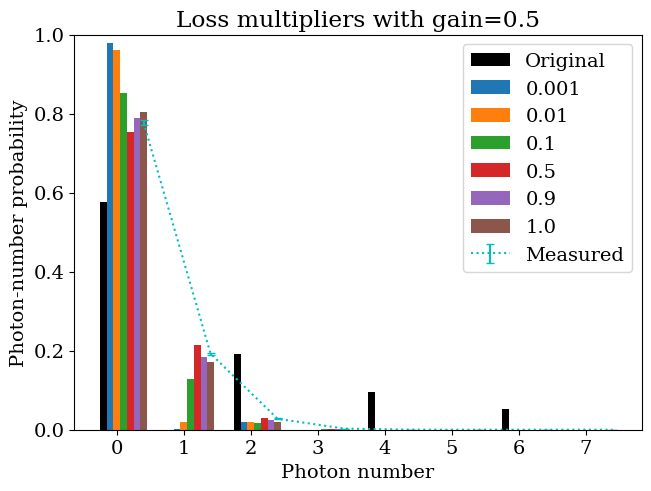

In [70]:
# Now do gain=0.5
coeffs_predict_real_restricted=[sim_circuit(gains[0],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[7.77075030e-01, 1.92384335e-01, 2.76381910e-02, 2.77248311e-03,
 1.29960146e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
yerr=[5.90591721e-03, 2.73269567e-03, 9.41817938e-04, 2.81355300e-04,
 7.71805551e-05, 1.99991404e-05, 4.97476056e-06, 1.20002532e-06]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(len(coeffs_predict_real_restricted[0]))]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=0.5')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain0_5.eps')

In [15]:
# What if we simulate the same circuit but assume the starting state to be lossy? We don't allow the first loops to "get better" when they're storing the state psi to be amplified from mode 2.
def sim_circuit_lossy_init(my_gain, improve_factor, cutoff_val):
    # This time we will want to compile manually, because the device certificate today may be different from when the experiment was conducted
    certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}

    # What if we make losses better, manually?
    original_loop_1=certificate_from_expt['loop_efficiencies'][0] # record this value because we actually are not going to improve it in the circuit for when the state is being stored until it interacts with anything else
    deviation_improvement_factor=improve_factor # If the current value is 1-eta, we add eta*factor to it to make it closer to a transmission of 1. 
    certificate_from_expt['common_efficiency']=deviation_improvement_factor+np.array(certificate_from_expt['common_efficiency'])*(1.-deviation_improvement_factor)
    certificate_from_expt['loop_efficiencies']=(deviation_improvement_factor+np.array(certificate_from_expt['loop_efficiencies'])*(1.-deviation_improvement_factor)).tolist()
    certificate_from_expt['relative_channel_efficiencies']=(deviation_improvement_factor+np.array(certificate_from_expt['relative_channel_efficiencies'])*(1.-deviation_improvement_factor)).tolist()
    

    # Let's define our circuit manually
    modes = 22 
    starting_mode = 0 # This can be modified if we are aiming for some particular detectors that are better than the rest)

    squeeze_level = "high"

    # squeezing-gate parameters. These will be rounded to the closest one supported by hardware
    r = [0.] * modes

    # rotation-gate parameters. These phases will not matter for the photon counting multiplexing we are doing here
    phi_0 = [0.] * modes
    phi_1 = [0.] * modes
    phi_2 = [0.] * modes


    # beamsplitter parameters. Set irrelevant transmission parameters to 1 to load all loops
    T_0 = [1.] * modes
    T_1 = [1.] * modes
    T_2 = [1.] * modes


    # Create a two-mode squeezed vacuum in the first two modes by interfering two single-mode squeezed vacuum states
    r[0+starting_mode] = certificate_from_expt["squeezing_parameters_mean"][squeeze_level] 
    r[1+starting_mode] = certificate_from_expt["squeezing_parameters_mean"][squeeze_level]

    # symmetric BS will convert two SV into one TMSV
    T_0[1+starting_mode] = 0.5 


    # Will postselect mode 0 to be in state |n> to herald mode 1 as starting in state |n>

    # Create a state to be amplified; here it's a single-mode squeezed vacuum
    r[2+starting_mode] = certificate_from_expt["squeezing_parameters_mean"][squeeze_level]
    # Delay the state psi in mode 2 to be amplified (all of the squeezed states needed to be in the first modes)
    T_0[2+starting_mode] = 1.
    delay_length = 11
    T_0[2+starting_mode+1:2+starting_mode+1+delay_length] = [0. for i in range(delay_length)]
    T_0[2+starting_mode+1+delay_length+1] = 1. # Just to make sure it gets out


    # Fixing phases
    #phi_0[8]= np.pi/2
    #phi_1[1] = np.pi
    phi_0[1+starting_mode+1:2+starting_mode+1+delay_length] = [-np.pi/2 for i in range(delay_length+1)] # The delays add phases too, even though they're just identity transformations



    # Amplification starts by a variable-transmissivity beam splitter between a vacuum state in mode 7 and the state |n> in mode 1. Will measure mode 1 as amplified state
    gain = my_gain
    tau = (1./gain)**2/(1.+(1./gain)**2)
    tau = 1./(1.+gain**2)
    print("tau is", tau)
    # We actually want the mode 1 to house the amplified state, which requires an extra swap relative to the paper
    # So we adjust the BS accordingly. This does a1-> sqrt(1-tau)a1-sqrt(tau)a2
    phi_1[1+starting_mode] += np.pi/2 # To fix the default phases from the beam splitter
    T_1[7+starting_mode] = 1.-tau 
    phi_2[1+starting_mode] += -np.pi/2 # To fix the default phases from the beam splitter



    # Next do QFT on modes 7, 2 delayed to 13, and 14. Then postselect on pattern 0,1,1 to get amplified state, but also will get the same state with different phases if postselect on 1,1,0 or 1,0,1, so that's good too.
    # The first BS does a13 -> sqrt(1/2)a13-sqrt(1/2)a14. Our phase choice will end up just adding a global phase
    T_0[14+starting_mode] = 0.5
    phi_0[2+starting_mode] += -np.pi/2 # Fix the phase. Since this must happen before going into the loop, that happened way back in time bin 2, which then remained in the loop for a long time
    phi_1[13+starting_mode] += np.pi/2 # Fix phase after exiting loop.

    phi_1[7]+=np.pi
    #phi_1[13]+=np.pi/2
    #phi_0[2+starting_mode] += np.pi/2


    # Now delay mode 14 an appropriate length so that it can intefere at the second loop
    delay_length2 = 5
    T_0[14+starting_mode+1:14+starting_mode+1+delay_length2] = [0. for i in range(delay_length2)]
    T_0[14+starting_mode+1+delay_length2+1] = 1. # Just to make sure it gets out
    phi_0[14+starting_mode+1:14+starting_mode+1+delay_length2] = [-np.pi/2 for i in range(delay_length2)]
    phi_1[19]+=-np.pi/2

    phi_0[2]+=-np.pi/2
    phi_0[8]+=-np.pi/2
    phi_0[14]+=-np.pi/2
    phi_2[7]+=np.pi/2
    phi_2[13]+=np.pi/2
    phi_2[19]+=-np.pi/2
    # Beam splitter between modes 7 and 13 at second loop
    phi_1[7+starting_mode] += np.pi/2 
    T_1[13+starting_mode] = 1./3  ### this one is not affecting anything yet
    phi_2[7+starting_mode] += -np.pi/2

    # Put phase on mode 14 that is now in mode 19
    phi_1[19]+=np.pi*3./2.




    # BS between modes 13 and 19 at second loop
    phi_1[19+starting_mode] += np.pi/2 # This will cancel with the one from before, anyway 
    T_1[19+starting_mode] = 0.5
    phi_2[19+starting_mode] += -np.pi/2

    # Finally, postselect on mode 19 having a 1, mode 13 having a 1, mode 7 having a 0. Already said to postselect on n=2 in mode 0. 
    # amplified state is in mode 1, so we will look at the (conditional) photon-number distribution there



    alpha_0 = np.arccos(np.sqrt(T_0))
    alpha_1 = np.arccos(np.sqrt(T_1))
    alpha_2 = np.arccos(np.sqrt(T_2))

    # the travel time per delay line in time bins
    delay_0, delay_1, delay_2 = 1, 6, 36

    # set the first beamsplitter arguments to 'T=1' ('alpha=0') to fill the
    # loops with pulses
    alpha_0[:delay_0] = 0.0
    alpha_1[:delay_1] = 0.0
    alpha_2[:delay_2] = 0.0

    #convert back to being lists so we can extend them
    alpha_0=alpha_0.tolist()
    alpha_1=alpha_1.tolist()
    alpha_2=alpha_2.tolist()

    ### Manual steps for compilation
    # second loop needs to await the first mode for 1 time bin (delay_0 = 1)
    phi_1 = [0] * delay_0 + phi_1
    alpha_1 = [0] * delay_0 + alpha_1
    # print(alpha_1)

    # second loop needs to await the first mode for 7 time bins (delay_0 + delay_1 = 1 + 6)
    phi_2 = [0] * (delay_0 + delay_1) + phi_2
    alpha_2 = [0] * (delay_0 + delay_1) + alpha_2

    # empty first loop (delay_0) and await the emptying of second and third loop
    # (delay_1 + delay_2)
    r += [0] * (delay_0 + delay_1 + delay_2)
    phi_0 += [0] * (delay_0 + delay_1 + delay_2)
    alpha_0 += [0] * (delay_0 + delay_1 + delay_2)

    # empty second loop (delay_1) and await the emptying of third loop (delay_2)
    phi_1 += [0] * (delay_1 + delay_2)
    alpha_1 += [0] * (delay_1 + delay_2)

    # empty third loop
    phi_2 += [0] * delay_2
    alpha_2 += [0] * delay_2

    gate_args_list = [r, phi_0, alpha_0, phi_1, alpha_1, phi_2, alpha_2]

    # the intrinsic roundtrip phase of each delay line
    phis_loop = certificate_from_expt["loop_phases"]

    # # Verify components if desired
    # print(gate_args_list[0])
    # #gate_args_list[0][0:modes]=r
    # #print(gate_args_list[0])

    delays = [1, 6, 36]
    vac_modes = sum(delays)

    n, N = get_mode_indices(delays)
    # print(vac_modes)
    # print(n,N)

    # Use this if want to manually add realistic losses gleaned from the device characteristics, can then be tweaked
    eta_glob = certificate_from_expt["common_efficiency"]
    etas_loop = certificate_from_expt["loop_efficiencies"]
    etas_ch_rel = certificate_from_expt["relative_channel_efficiencies"]

    prog_length = len(gate_args_list[0])
    reps = int(np.ceil(prog_length / 16))
    etas_ch_rel = np.tile(etas_ch_rel, reps)[:prog_length]
    etas_ch_rel = etas_ch_rel.tolist()

    gate_args_list += [etas_ch_rel]
    
    
    
    from strawberryfields.ops import LossChannel
    print("minimum loss for any mode is: ", 1-eta_glob)

    from strawberryfields.ops import LossChannel

    prog = sf.TDMProgram(N)

    with prog.context(*gate_args_list) as (p, q):
        Sgate(p[0]) | q[n[0]]
        LossChannel(eta_glob) | q[n[0]]
        for i in range(len(delays)):
            Rgate(p[2 * i + 1]) | q[n[i]]
            BSgate(p[2 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
            #Rgate(phis_loop[i]) | q[n[i]]
            LossChannel(etas_loop[i]) | q[n[i]] # need a manual loop over n such that we can apply the standard loss to most modes but keep the loss fixed for the first loop for 11 of the rounds
        #switch this etaloops loss channel to an argument of the gate, go into p, then do manually?
        #if so, verify that circuits are the same
        LossChannel(p[7]) | q[0]
        MeasureFock() | q[0]

    #prog.print()

    # What if we want all of the loss parameters to also be in the list?
    num_modes=len(gate_args_list[0])
    eta_0=[etas_loop[0] for i in range(num_modes)]
    eta_1=[etas_loop[1] for i in range(num_modes)]
    eta_2=[etas_loop[2] for i in range(num_modes)]
    num_start=3
    num_wait=11
    eta_0[num_start:num_start+num_wait]=[original_loop_1 for i in range(num_start,num_start+num_wait)] # assume we started with this lossy state
    gate_args_list2 = [r, phi_0, alpha_0, eta_0, phi_1, alpha_1, eta_1, phi_2, alpha_2, eta_2]
    gate_args_list2 += [etas_ch_rel]

    #print(gate_args_list2)
    
    prog2 = sf.TDMProgram(N)

    with prog2.context(*gate_args_list2) as (p, q):
        Sgate(p[0]) | q[n[0]]
        LossChannel(eta_glob) | q[n[0]]
        for i in range(len(delays)):
            Rgate(p[3 * i + 1]) | q[n[i]]
            BSgate(p[3 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
            #Rgate(phis_loop[i]) | q[n[i]]
            LossChannel(p[3 * i + 3]) | q[n[i]] # need a manual loop over n such that we can apply the standard loss to most modes but keep the loss fixed for the first loop for 11 of the rounds
        #switch this etaloops loss channel to an argument of the gate, go into p, then do manually?
        #if so, verify that circuits are the same
        LossChannel(p[10]) | q[0]
        MeasureFock() | q[0]

    #prog2.print()
    
    eng_sim = sf.Engine(backend="gaussian")
    results_sim = eng_sim.run(prog, shots=None, space_unroll=True, crop=True) # Using manual loss from specific device

    state = results_sim.state
    
    eng_sim2 = sf.Engine(backend="gaussian")
    results_sim2 = eng_sim2.run(prog2, shots=None, space_unroll=True, crop=True) # Using manual loss from specific device

    state2 = results_sim2.state

    # Verification: it works
    #print("Covariance matrix difference between two methods:", np.sum(np.abs(np.array(state.cov())-np.array(state2.cov()))))
    #print("Means vector difference between two methods:", np.sum(np.abs(np.array(state.means())-np.array(state2.means()))))
    
    # reduced_state=state.reduced_gaussian([0,1,7,13,19])
    # from thewalrus.quantum import state_vector, density_matrix
    # mu0=reduced_state[0]
    # cov0=reduced_state[1]
    low_cutoff=3
    # rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)


    # Finally, postselect on mode 19 having a 1, mode 13 having a 1, mode 7 having a 0. Already said to postselect on n=2 in mode 0. 
    # amplified state is in mode 1, so we will look at the (conditional) photon-number distribution there
    max_photon_out = low_cutoff
    high_cutoff=cutoff_val
    extra=5
    amplified_probs = [0. for i in range(max_photon_out+extra)]
    for j in range(max_photon_out+extra):
        locations = [2,j,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
        amplified_probs[j] = state2.fock_prob(locations[0:modes],cutoff=high_cutoff) 
        locations = [2,j,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
        amplified_probs[j] += state2.fock_prob(locations[0:modes],cutoff=high_cutoff) 
        locations = [2,j,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
        amplified_probs[j] += state2.fock_prob(locations[0:modes],cutoff=high_cutoff) 
    # # Can use any of the options 011, 110, 101 for the modes 7,13,19 since we aren't measuring the phase
    # amplified_probs1 = [0. for i in range(max_photon_out)]
    # for j in range(max_photon_out):
    #     amplified_probs1[j] = rho0[2,2,j,j,0,0,1,1,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
    # amplified_probs2 = [0. for i in range(max_photon_out)]
    # for j in range(max_photon_out):
    #     amplified_probs2[j] = rho0[2,2,j,j,1,1,1,1,0,0] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
    # amplified_probs3 = [0. for i in range(max_photon_out)]
    # for j in range(max_photon_out):
    #     amplified_probs3[j] = rho0[2,2,j,j,1,1,0,0,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
    # print(amplified_probs)
    # print(amplified_probs1)
    # print(amplified_probs2)
    # print(amplified_probs3)

    # print("Average from all three runs ",(amplified_probs/np.sum(amplified_probs)).tolist())
    # print((amplified_probs1/np.sum(amplified_probs1)).round(8)) # Same results approximately for each pattern, even with realistic losses
    # print((amplified_probs2/np.sum(amplified_probs2)).round(8)) 
    # print((amplified_probs3/np.sum(amplified_probs3)).round(8)) 

    # expected_probs = [gain**(2*2*i) *np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(2*i)*np.math.factorial(2*i)
    #                   /2**(2*i)/np.math.factorial(i)**2/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level]) 
    #                   for i in range(2)]
    # expected_probs=expected_probs/np.sum(expected_probs)
    # print("coefficients squared of 0 and 2 expected to be",expected_probs)
    # print("coefficients squared of 0 and 2 expected to be",[1, np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**2 * gain**(4)/2]/np.sum([1, np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**2 * gain**4/2]))
    # print("original coefficients of 0 and 2 proportional to",[1, np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])*np.sqrt(2.)/2])
    return (amplified_probs/np.sum(amplified_probs)).tolist()

tau is 0.2
minimum loss for any mode is:  0.0
tau is 0.2
minimum loss for any mode is:  0.0006140000000000034
tau is 0.2
minimum loss for any mode is:  0.006140000000000034
tau is 0.2
minimum loss for any mode is:  0.06140000000000001
tau is 0.2
minimum loss for any mode is:  0.30699999999999994
tau is 0.2
minimum loss for any mode is:  0.5526
tau is 0.2
minimum loss for any mode is:  0.614
[[0.30585348328019324, 0.24393487018591342, 0.45021164653389256, 9.076178411011827e-16, 1.7854777201990477e-16, -1.4135031951575798e-17, -3.2535371790293765e-16, -3.0466484908158366e-18], [0.3049646008016456, 0.24573494803651694, 0.44857919365617094, 0.0007204831331444403, 7.736777576293366e-07, 6.942010114752004e-10, 5.630030878388871e-13, 4.1519271036382743e-16], [0.2973730317927251, 0.2610623934456645, 0.43461184474045017, 0.006879142475026748, 7.293588449152033e-05, 6.464517241610178e-07, 5.171206361681965e-09, 3.8711458699859896e-11], [0.25171170104767326, 0.35275642591850137, 0.344066730293012

/opt/conda/envs/pennylane/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part


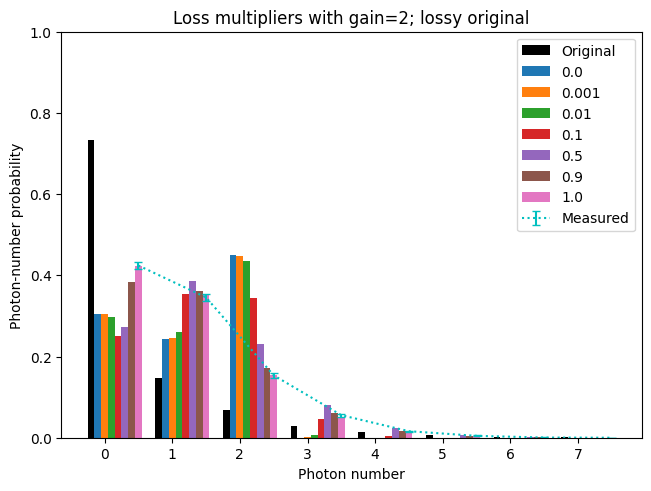

In [ ]:
# What is expected photon-number distribution from lossy squeezed state?
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze_level="high"
num_wait=11
transmit_prob=certificate_from_expt["loop_efficiencies"][0]**num_wait # State had to wait at the first loop this main times before interacting with anything else
from thewalrus.quantum import state_vector, density_matrix
mu0=np.array([ 0 , 0])
cov0=np.array(
    [
        [
            1+(-1+np.exp(-2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob,0],
               [0,1+(-1+np.exp(2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob]])
low_cutoff=8
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)
#np.diagonal(rho0)

#from scipy.special import factorial
#original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(8)]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
#print(original_coeffs)
#np.diagonal(rho0)

cutoff_val=15
gains=[0.5, 1.0, 2.0, 4.0]
noise_factors=[ 0.999, 0.99, 0.9, 0.5, 0.1, 0.]

# Now do gain=2
coeffs_predict_real_restricted=[sim_circuit_lossy_init(gains[2],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[0.42414929, 0.34555434 ,0.15367728, 0.05554336, 0.01602634 ,0.00461032,
 0.00043908, 0.        ]
yerr=[0.00963292, 0.00880683, 0.00583821, 0.00332811, 0.00174731, 0.00087073,
 0.00041841, 0.0001957 ]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=np.diagonal(rho0)
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=2; lossy original')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain2_initLossy.eps')

tau is 0.058823529411764705
minimum loss for any mode is:  0.0006140000000000034
tau is 0.058823529411764705
minimum loss for any mode is:  0.006140000000000034
tau is 0.058823529411764705
minimum loss for any mode is:  0.06140000000000001
tau is 0.058823529411764705
minimum loss for any mode is:  0.30699999999999994
tau is 0.058823529411764705
minimum loss for any mode is:  0.5526
tau is 0.058823529411764705
minimum loss for any mode is:  0.614
[[0.036058917861313086, 0.11689491928528514, 0.8454464411841877, 0.001597701185424912, 2.01835130587764e-06, 2.1304515155728507e-09, 2.030038673124213e-12, 1.7668131359057674e-15], [0.03629464305527412, 0.13332917952121726, 0.8149928376749282, 0.015191932722255544, 0.00018941480722521088, 1.9735013247122852e-06, 1.855453940543505e-08, 1.632354988857882e-10], [0.047863335051548654, 0.24788285376913152, 0.5964739844286845, 0.09620055819811607, 0.010527035473441063, 0.000965938645207451, 8.007914595102637e-05, 6.215287919809447e-06], [0.1657592140

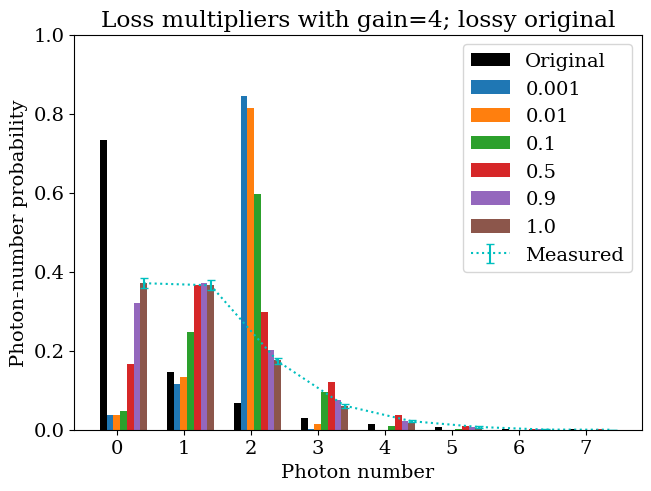

In [73]:
# Now do gain=4
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze_level="high"
num_wait=11
transmit_prob=certificate_from_expt["loop_efficiencies"][0]**num_wait # State had to wait at the first loop this main times before interacting with anything else
from thewalrus.quantum import state_vector, density_matrix
mu0=np.array([ 0 , 0])
cov0=np.array(
    [
        [
            1+(-1+np.exp(-2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob,0],
               [0,1+(-1+np.exp(2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob]])
low_cutoff=8
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)
#np.diagonal(rho0)

#from scipy.special import factorial
#original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(8)]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
#print(original_coeffs)
#np.diagonal(rho0)

cutoff_val=15
gains=[0.5, 1.0, 2.0, 4.0]
noise_factors=[ 0.999, 0.99, 0.9, 0.5, 0.1, 0.]

coeffs_predict_real_restricted=[sim_circuit_lossy_init(gains[3],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[0.37088247, 0.36559577, 0.17364782, 0.06100041, 0.02155348, 0.00691338,
 0.00040667, 0.        ]
yerr=[0.01230012, 0.01220212, 0.00848413, 0.00498187, 0.00268595, 0.00137674,
 0.00068268, 0.00033073]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=np.diagonal(rho0)
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=4; lossy original')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain4_initLossy.eps')

tau is 0.5
minimum loss for any mode is:  0.0006140000000000034
tau is 0.5
minimum loss for any mode is:  0.006140000000000034
tau is 0.5
minimum loss for any mode is:  0.06140000000000001
tau is 0.5
minimum loss for any mode is:  0.30699999999999994
tau is 0.5
minimum loss for any mode is:  0.5526
tau is 0.5
minimum loss for any mode is:  0.614
[[0.7721893441919937, 0.1565580207520406, 0.07118114790661176, 7.143917248975911e-05, 4.794995633083128e-08, 2.6894396633860162e-11, 1.3512008419704048e-14, 6.645568126389157e-18], [0.7533452876061331, 0.17505560686871482, 0.0708946862849898, 0.0006997510435512237, 4.6422967841979395e-06, 2.577005548934309e-08, 1.2916526426745736e-10, 6.060165119910562e-13], [0.619463845384843, 0.2918125437386722, 0.0815037014194837, 0.00678993721803967, 0.00040802061359242924, 2.0930951805854365e-05, 9.7774238042948e-07, 4.2931182725146826e-08], [0.4920011484991286, 0.3543562823218684, 0.12010895363023055, 0.027436234117350997, 0.005112300959008393, 0.00084035

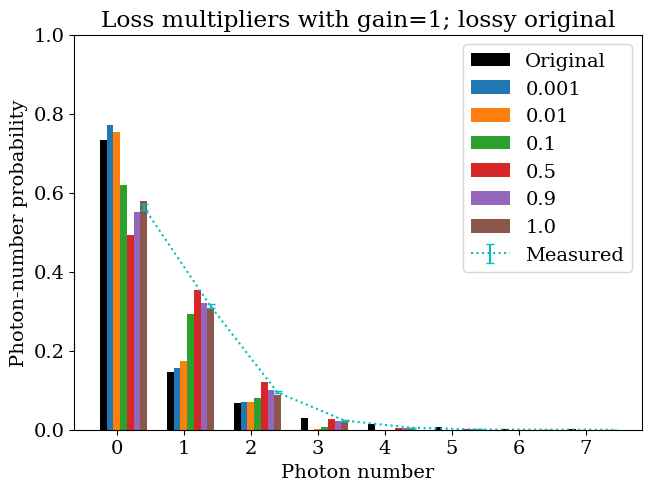

In [74]:
# Now do gain=1
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze_level="high"
num_wait=11
transmit_prob=certificate_from_expt["loop_efficiencies"][0]**num_wait # State had to wait at the first loop this main times before interacting with anything else
from thewalrus.quantum import state_vector, density_matrix
mu0=np.array([ 0 , 0])
cov0=np.array(
    [
        [
            1+(-1+np.exp(-2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob,0],
               [0,1+(-1+np.exp(2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob]])
low_cutoff=8
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)
#np.diagonal(rho0)

#from scipy.special import factorial
#original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(8)]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
#print(original_coeffs)
#np.diagonal(rho0)

cutoff_val=15
gains=[0.5, 1.0, 2.0, 4.0]
noise_factors=[ 0.999, 0.99, 0.9, 0.5, 0.1, 0.]

coeffs_predict_real_restricted=[sim_circuit_lossy_init(gains[1],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[5.63767322e-01, 3.12769122e-01, 9.43396226e-02, 2.31738824e-02,
 5.08885931e-03, 7.04611289e-04, 1.56580287e-04, 0.00000000e+00]
yerr=[6.73984762e-03, 4.90261660e-03, 2.64157405e-03, 1.23219516e-03,
 5.28173965e-04, 2.14061650e-04, 8.33516615e-05, 3.14940109e-05]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=np.diagonal(rho0)
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=1; lossy original')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain1_initLossy.eps')

tau is 0.8
minimum loss for any mode is:  0.0006140000000000034
tau is 0.8
minimum loss for any mode is:  0.006140000000000034
tau is 0.8
minimum loss for any mode is:  0.06140000000000001
tau is 0.8
minimum loss for any mode is:  0.30699999999999994
tau is 0.8
minimum loss for any mode is:  0.5526
tau is 0.8
minimum loss for any mode is:  0.614
[[0.9461787578717336, 0.04835583864606783, 0.005463210161804053, 2.1927315078433897e-06, 5.887545223700686e-10, 1.3211088808113223e-13, 2.654357002921213e-17, -7.807817727115076e-21], [0.9360658687559122, 0.058257025762685585, 0.005654772980753461, 2.227317629509332e-05, 5.919231972625592e-08, 1.3176852999112618e-10, 2.6499349053723435e-13, 4.990076254501558e-16], [0.8574567697933295, 0.13180499358597855, 0.01038763856585959, 0.00034200931943816656, 8.407265345565796e-06, 1.7797008600947808e-07, 3.4375772943123466e-09, 6.238516242406708e-11], [0.7614915460088425, 0.208098461446613, 0.02763292267561174, 0.002567163026420096, 0.000195869012367804

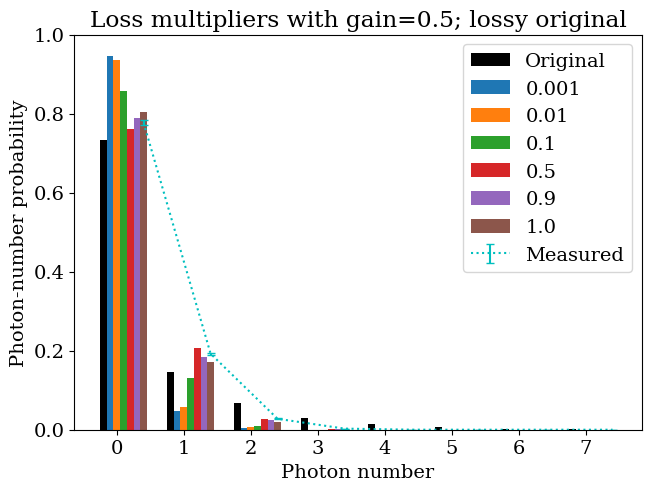

In [75]:
# Now do gain=0.5
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze_level="high"
num_wait=11
transmit_prob=certificate_from_expt["loop_efficiencies"][0]**num_wait # State had to wait at the first loop this main times before interacting with anything else
from thewalrus.quantum import state_vector, density_matrix
mu0=np.array([ 0 , 0])
cov0=np.array(
    [
        [
            1+(-1+np.exp(-2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob,0],
               [0,1+(-1+np.exp(2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob]])
low_cutoff=8
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)
#np.diagonal(rho0)

#from scipy.special import factorial
#original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(8)]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])
#print(original_coeffs)
#np.diagonal(rho0)

cutoff_val=15
gains=[0.5, 1.0, 2.0, 4.0]
noise_factors=[ 0.999, 0.99, 0.9, 0.5, 0.1, 0.]

coeffs_predict_real_restricted=[sim_circuit_lossy_init(gains[0],noise_factors[i],cutoff_val) for i in range(len(noise_factors))]
print(coeffs_predict_real_restricted)
y=[7.77075030e-01, 1.92384335e-01, 2.76381910e-02, 2.77248311e-03,
 1.29960146e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
yerr=[5.90591721e-03, 2.73269567e-03, 9.41817938e-04, 2.81355300e-04,
 7.71805551e-05, 1.99991404e-05, 4.97476056e-06, 1.20002532e-06]
import matplotlib.pyplot as plt

width = 0.1  # the width of the bars
multiplier = 0
x = np.arange(len(coeffs_predict_real_restricted[0]))-width  # the label locations

fig, ax = plt.subplots(layout='constrained')

from scipy.special import factorial
original_coeffs=np.diagonal(rho0)
ax.bar(x - width, original_coeffs, width, label='Original',color='k')

for i in range(len(noise_factors)):
    offset = width * multiplier
    rects = ax.bar(x + offset, coeffs_predict_real_restricted[i], width, label=str(round(1.-noise_factors[i], 3)))
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.errorbar(x+offset, y , yerr=yerr, label='Measured',linestyle=':',capsize=3,color='c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Photon number')
ax.set_ylabel('Photon-number probability')
ax.set_title('Loss multipliers with gain=0.5; lossy original')
#ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
#plt.yscale('log')
#plt.ylim([0.0001,1])

plt.savefig('numberDistributionVsLossGain05_initLossy.eps')

/opt/conda/envs/pennylane/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


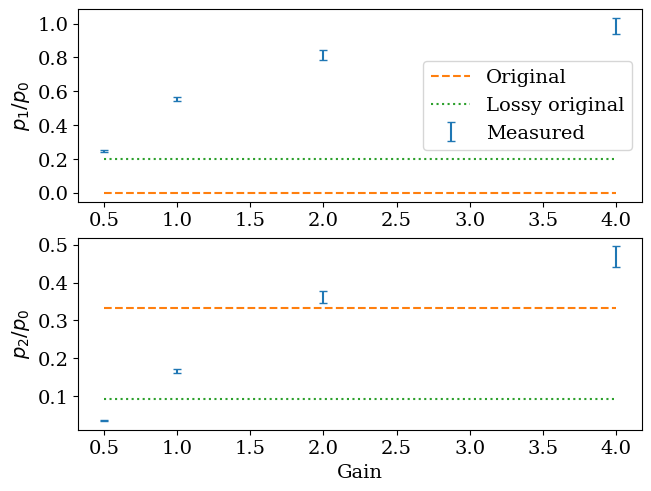

In [76]:
# Now let's plot the coefficient ratios that we get versus what they started as. Might be a sign of gain?
certificate_from_expt={'finished_at': '2023-05-29T17:41:34.623450+00:00', 'target': 'borealis', 'loop_phases': [1.268, -0.051, 1.848], 'schmidt_number': 1.151, 'common_efficiency': 0.386, 'loop_efficiencies': [0.88, 0.879, 0.793], 'squeezing_parameters_mean': {'low': 0.678, 'high': 1.148, 'medium': 1.06}, 'relative_channel_efficiencies': [0.918, 0.938, 0.912, 1.0, 0.961, 0.917, 0.893, 0.969, 0.951, 0.955, 0.965, 0.998, 0.947, 0.966, 0.947, 0.898]}
squeeze_level="high"
num_wait=11
transmit_prob=certificate_from_expt["loop_efficiencies"][0]**num_wait # State had to wait at the first loop this main times before interacting with anything else
from thewalrus.quantum import state_vector, density_matrix
mu0=np.array([ 0 , 0])
cov0=np.array(
    [
        [
            1+(-1+np.exp(-2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob,0],
               [0,1+(-1+np.exp(2*certificate_from_expt["squeezing_parameters_mean"][squeeze_level]))*transmit_prob]])
low_cutoff=8
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)
original_coeffs_loss=np.diagonal(rho0)

from scipy.special import factorial
original_coeffs=[((i-1)%2)*np.tanh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])**(i)*factorial(i)/2**i/factorial(i/2)**2 for i in range(8)]/np.cosh(certificate_from_expt["squeezing_parameters_mean"][squeeze_level])


gains=[0.5, 1.0, 2.0, 4.0]

y05=[7.77075030e-01, 1.92384335e-01, 2.76381910e-02, 2.77248311e-03,
 1.29960146e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
yerr05=[5.90591721e-03, 2.73269567e-03, 9.41817938e-04, 2.81355300e-04,
 7.71805551e-05, 1.99991404e-05, 4.97476056e-06, 1.20002532e-06]
y1=[5.63767322e-01, 3.12769122e-01, 9.43396226e-02, 2.31738824e-02,
 5.08885931e-03, 7.04611289e-04, 1.56580287e-04, 0.00000000e+00]
yerr1=[6.73984762e-03, 4.90261660e-03, 2.64157405e-03, 1.23219516e-03,
 5.28173965e-04, 2.14061650e-04, 8.33516615e-05, 3.14940109e-05]
y4=[0.37088247, 0.36559577, 0.17364782, 0.06100041, 0.02155348, 0.00691338,
 0.00040667, 0.        ]
yerr4=[0.01230012, 0.01220212, 0.00848413, 0.00498187, 0.00268595, 0.00137674,
 0.00068268, 0.00033073]
y2=[0.42414929, 0.34555434 ,0.15367728, 0.05554336, 0.01602634 ,0.00461032,
 0.00043908, 0.        ]
yerr2=[0.00963292, 0.00880683, 0.00583821, 0.00332811, 0.00174731, 0.00087073,
 0.00041841, 0.0001957 ]

pIoverp0=[[y05[i]/y05[0],y1[i]/y1[0],y2[i]/y2[0],y4[i]/y4[0]] for i in range(3)]
errorPiOverP0=[[y05[i]/y05[0] *np.sqrt((yerr05[i]/y05[i])**2+(yerr05[0]/y05[0])**2),y1[i]/y1[0] *np.sqrt((yerr1[i]/y1[i])**2+(yerr1[0]/y1[0])**2),y2[i]/y2[0] *np.sqrt((yerr2[i]/y2[i])**2+(yerr2[0]/y2[0])**2),y4[i]/y4[0] *np.sqrt((yerr4[i]/y4[i])**2+(yerr4[0]/y4[0])**2)] for i in range(3)]

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern Roman']
rcParams.update({'font.size': 14})

#plt.style.use('ggplot')

fig, ax = plt.subplots(2,layout='constrained')
# Old labels:
# ax[0].plot(gains,pIoverp0[1],linestyle=':',label=r'measured $p_1/p_0$', marker='o')
# ax[0].plot(gains,[original_coeffs[1]/original_coeffs[0] for i in range(len(gains))],label=r'original $p_1/p_0$', linestyle='dashed')
# ax[0].plot(gains,[original_coeffs_loss[1]/original_coeffs_loss[0] for i in range(len(gains))],label=r'lossy original $p_1/p_0$')
# ax[1].plot(gains,pIoverp0[2],linestyle=':',label=r'measured $p_2/p_0$', marker='o')
# ax[1].plot(gains,[original_coeffs[2]/original_coeffs[0] for i in range(len(gains))],label=r'original $p_2/p_0$', linestyle='dashed')
# ax[1].plot(gains,[original_coeffs_loss[2]/original_coeffs_loss[0] for i in range(len(gains))],label=r'lossy original $p_2/p_0$')

#ax[0].plot(gains,pIoverp0[1],linestyle=':',label='Measured', marker='o')
ax[0].errorbar(gains, pIoverp0[1] , yerr=errorPiOverP0[1], label='Measured',linestyle='',capsize=3)#, elinewidth=1,markeredgewidth=2 are possible options
ax[0].plot(gains,[original_coeffs[1]/original_coeffs[0] for i in range(len(gains))],label='Original', linestyle='dashed')
ax[0].plot(gains,[original_coeffs_loss[1]/original_coeffs_loss[0] for i in range(len(gains))],label='Lossy original',linestyle=':')
ax[1].errorbar(gains, pIoverp0[2] , yerr=errorPiOverP0[2], label='Measured',linestyle='',capsize=3)
#ax[1].plot(gains,pIoverp0[2],linestyle=':',label=r'measured $p_2/p_0$', marker='o')
ax[1].plot(gains,[original_coeffs[2]/original_coeffs[0] for i in range(len(gains))],label=r'original $p_2/p_0$', linestyle='dashed')
ax[1].plot(gains,[original_coeffs_loss[2]/original_coeffs_loss[0] for i in range(len(gains))],label=r'lossy original $p_2/p_0$',linestyle=':')
ax[1].set_xlabel('Gain')
ax[1].set_ylabel(r'$p_2/p_0$')
ax[0].set_ylabel(r'$p_1/p_0$')
ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.1))


ax[0].legend()
#ax[1].legend()
plt.savefig('Gains.eps')

In [25]:
# Choose a tolerance for error, like 10% of the expected value. What loss multiplier is necessary to achieve that? Start with lossy state, g=2.
cutoff_val=15
gains=[0.5, 1.0, 2.0, 4.0]
noise_factors=[ 0.999, 0.99, 0.9, 0.5, 0.1, 0.]

# Now do gain=2
perfect_coeffs=sim_circuit_lossy_init(gains[2],1.0,cutoff_val)
print('lossless distributions',perfect_coeffs)
for i in range(3):
    noise_fact=1.-0.015+0.001*i
    new_coeffs=sim_circuit_lossy_init(gains[2],noise_fact,cutoff_val)
    print('with losses multiplied by',str(round(1.-noise_fact, 3)),'distribution is',new_coeffs)
    deviations=[new_coeffs[i]/perfect_coeffs[i] for i in range(len(perfect_coeffs))]
    print('deviations are',deviations)
    if all([deviations[i]<1.1 and deviations[i]>1./1.1 for i in range(3)]):
        print('success')
    else:
        print('fail')


tau is 0.2
minimum loss for any mode is:  0.0
lossless distributions [0.30585348328019324, 0.24393487018591342, 0.45021164653389256, 9.076178411011827e-16, 1.7854777201990477e-16, -1.4135031951575798e-17, -3.2535371790293765e-16, -3.0466484908158366e-18]
tau is 0.2
minimum loss for any mode is:  0.009210000000000051
with losses multiplied by 0.015 distribution is [0.29345841782776844, 0.2689353519905735, 0.4273810569982324, 0.010064112459279344, 0.00015893654048634457, 2.0988857620209668e-06, 2.501879614266036e-08, 2.7910158857766283e-10]
deviations are [0.9594738457136692, 1.1024883477528495, 0.9492892071730503, 11088491216819.723, 890162552510.7426, -148488221972.9952, -76897219.13712443, -91609383.03812152]
fail
tau is 0.2
minimum loss for any mode is:  0.008596000000000048
with losses multiplied by 0.014 distribution is [0.294224732076346, 0.2673957107963927, 0.42879863458462264, 0.009439848951901442, 0.00013933457338730375, 1.7196605959753291e-06, 1.9157031638534812e-08, 1.9972223

In [14]:
# Now do gain=4
perfect_coeffs=sim_circuit_lossy_init(gains[3],1.0,cutoff_val)
print('lossless distributions',perfect_coeffs)
for i in range(3):
    noise_fact=1.-0.008+0.001*i
    new_coeffs=sim_circuit_lossy_init(gains[3],noise_fact,cutoff_val)
    print('with losses multiplied by',str(round(1.-noise_fact, 3)),'distribution is',new_coeffs)
    deviations=[new_coeffs[i]/perfect_coeffs[i] for i in range(len(perfect_coeffs))]
    print('deviations are',deviations)
    if all([deviations[i]<1.1 and deviations[i]>1./1.1 for i in range(3)]):
        print('success')
    else:
        print('fail')


tau is 0.058823529411764705
minimum loss for any mode is:  0.0
lossless distributions [0.03604646188959067, 0.1149960943049779, 0.8489574438054186, 2.0068523915370476e-15, 8.757174072161663e-15, 1.2162741766891198e-17, 1.98928398676265e-15, 5.801434763413977e-17]
tau is 0.058823529411764705
minimum loss for any mode is:  0.0049120000000000275
with losses multiplied by 0.008 distribution is [0.03622349529407157, 0.1297767181927645, 0.8215864112877275, 0.012289401311098796, 0.000122938435557808, 1.0276721685568509e-06, 7.751895594551592e-09, 5.471577486994443e-11]
deviations are [1.0049112560623328, 1.1285315295021006, 0.9677592407989245, 6123719593390.8955, 14038596760.183083, 84493462761.3593, 3896827.022252858, 943142.1208940006]
fail
tau is 0.058823529411764705
minimum loss for any mode is:  0.004298000000000024
with losses multiplied by 0.007 distribution is [0.036191868760227494, 0.12797951173470062, 0.8249197853505178, 0.010813346139782637, 9.478907578219931e-05, 6.94321295831014e

In [20]:
# Now do gain=1
perfect_coeffs=sim_circuit_lossy_init(gains[1],1.0,cutoff_val)
print('lossless distributions',perfect_coeffs)
for i in range(3):
    noise_fact=1.-0.008+0.001*i
    new_coeffs=sim_circuit_lossy_init(gains[1],noise_fact,cutoff_val)
    print('with losses multiplied by',str(round(1.-noise_fact, 3)),'distribution is',new_coeffs)
    deviations=[new_coeffs[i]/perfect_coeffs[i] for i in range(len(perfect_coeffs))]
    print('deviations are',deviations)
    if all([deviations[i]<1.1 and deviations[i]>1./1.1 for i in range(3)]):
        print('success')
    else:
        print('fail')


tau is 0.5
minimum loss for any mode is:  0.0
lossless distributions [0.7743607855803276, 0.15439876283390044, 0.07124045158577162, 1.7328498845315183e-16, 2.832832854712395e-16, 2.1095563811688047e-18, -7.453765880129779e-17, -3.717734353717983e-19]
tau is 0.5
minimum loss for any mode is:  0.0049120000000000275
with losses multiplied by 0.008 distribution is [0.7574263274425169, 0.17108676442087556, 0.07092179234007664, 0.0005621115389876417, 2.9908922459474662e-06, 1.3311609576490207e-08, 5.3486454098217554e-11, 2.0115369475620556e-13]
deviations are [0.9781310489204079, 1.1080837778792811, 0.9955269900933836, 3243855939313.58, 10557955231.887897, 6310146386.850717, -717576.2555247615, -541065.2715276399]
fail
tau is 0.5
minimum loss for any mode is:  0.004298000000000024
with losses multiplied by 0.007 distribution is [0.7594893275710619, 0.16907257580230559, 0.07094287894990484, 0.0004929109007884999, 2.297785825126175e-06, 8.958480814813307e-09, 3.152923850210609e-11, 1.038588787

In [24]:
# Now do gain=0.5
perfect_coeffs=sim_circuit_lossy_init(gains[0],1.0,cutoff_val)
print('lossless distributions',perfect_coeffs)
for i in range(3):
    noise_fact=1.-0.006+0.001*i
    new_coeffs=sim_circuit_lossy_init(gains[0],noise_fact,cutoff_val)
    print('with losses multiplied by',str(round(1.-noise_fact, 3)),'distribution is',new_coeffs)
    deviations=[new_coeffs[i]/perfect_coeffs[i] for i in range(len(perfect_coeffs))]
    print('deviations are',deviations)
    if all([deviations[i]<1.1 and deviations[i]>1./1.1 for i in range(3)]):
        print('success')
    else:
        print('fail')


tau is 0.8
minimum loss for any mode is:  0.0
lossless distributions [0.9473311304140063, 0.04722177221963365, 0.0054470973663600635, 4.320488402406822e-18, -5.580630853108811e-18, -6.863275847573337e-20, 1.7551984134777724e-19, -1.053258014688768e-20]
tau is 0.8
minimum loss for any mode is:  0.0036840000000000206
with losses multiplied by 0.006 distribution is [0.9405034734442235, 0.05392366157363873, 0.005559593374749028, 1.325035845028456e-05, 2.1220469305559153e-08, 2.8434800858657062e-11, 3.440380086289452e-14, 3.8969117287279146e-17]
deviations are [0.9927927450596932, 1.1419237152479975, 1.0206524687962641, 3066865876298.4204, -3802521590.1420593, -414303628.3280209, 196010.8931202051, -3699.8643014166196]
fail
tau is 0.8
minimum loss for any mode is:  0.003070000000000017
with losses multiplied by 0.005 distribution is [0.9416270572301563, 0.052823646692431656, 0.005538258701456135, 1.1022632063374493e-05, 1.4727416224377425e-08, 1.645973789741206e-11, 1.6608105347740078e-14, 

In [32]:
import scipy
from scipy import stats
# Put them all together?
cutoff_val=15
gains=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16]
noise_factors=np.sort([0.9999, 0.999, 0.99, 0.9, 1.0-0.1*np.sqrt(10), 1.0-0.01*np.sqrt(10), 1.0-0.001*np.sqrt(10), 1.0-0.0001*np.sqrt(10), 0.]).tolist()
print(noise_factors)
KL_divergences=[[0. for gain in range(len(gains))] for i in range(len(noise_factors))]

for gain in range(len(gains)):
    perfect_coeffs=sim_circuit_lossy_init(gains[gain],1.0,cutoff_val)
    print('lossless distributions',perfect_coeffs)
    for i in range(len(noise_factors)):
        noise_fact=noise_factors[i]
        new_coeffs=sim_circuit_lossy_init(gains[gain],noise_fact,cutoff_val)
        KL_divergences[i][gain]=scipy.stats.entropy(new_coeffs[0:3],qk=perfect_coeffs[0:3])
        print('gain',gains[gain],'noise multiplier',1-noise_fact,'KL divergence',KL_divergences[i][gain])
print(KL_divergences)

[0.0, 0.683772233983162, 0.9, 0.9683772233983162, 0.99, 0.9968377223398316, 0.999, 0.9996837722339832, 0.9999]
tau is 0.9411764705882353
minimum loss for any mode is:  0.0
lossless distributions [0.987341138532328, 0.012304039435100004, 0.00035482203257217957, -8.895988105198758e-20, 1.991006861639722e-18, 2.5417108871996457e-21, 1.778315082537252e-20, -3.8941026446799805e-23]
tau is 0.9411764705882353
minimum loss for any mode is:  0.614
gain 0.25 noise multiplier 1.0 KL divergence 0.049617486677567935
tau is 0.9411764705882353
minimum loss for any mode is:  0.19416384833433853
gain 0.25 noise multiplier 0.316227766016838 KL divergence 0.06529150710739748
tau is 0.9411764705882353
minimum loss for any mode is:  0.06140000000000001
gain 0.25 noise multiplier 0.09999999999999998 KL divergence 0.021342766224302537
tau is 0.9411764705882353
minimum loss for any mode is:  0.019416384833433886
gain 0.25 noise multiplier 0.03162277660168378 KL divergence 0.003678329578390698
tau is 0.9411764

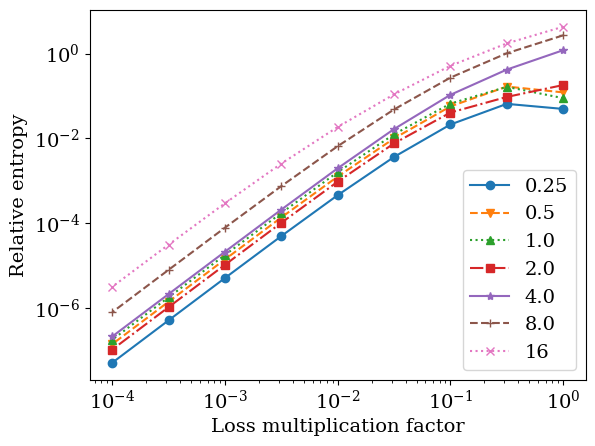

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern Roman']
rcParams.update({'font.size': 14})
linestyles=['-','--',':','-.','-','--',':','-.']
markers=['o','v','^','s','*','+','x']
for gain in range(len(gains)):
    plt.plot(1.-np.array(noise_factors),np.array(KL_divergences)[:,gain],label=gains[gain],linestyle=linestyles[gain],marker=markers[gain])
plt.legend()
#plt.plot(1.-np.array(noise_factors),KL_divergences,marker='o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Loss multiplication factor')
plt.ylabel('Relative entropy')
plt.savefig('KL_divergences_vsLoss.eps')
plt.show()

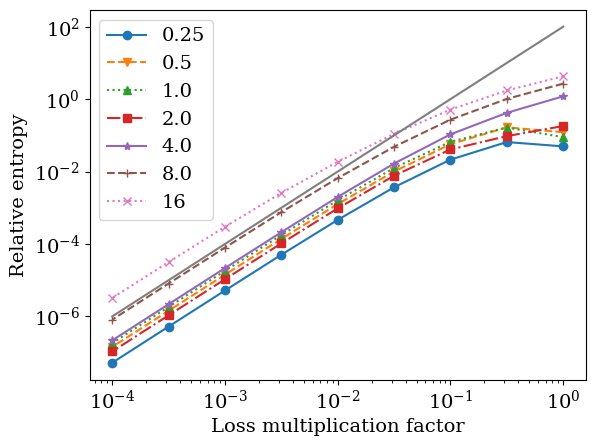

In [34]:
# Just checking that the scaling is quadratic
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern Roman']
rcParams.update({'font.size': 14})
linestyles=['-','--',':','-.','-','--',':','-.']
markers=['o','v','^','s','*','+','x']
for gain in range(len(gains)):
    plt.plot(1.-np.array(noise_factors),np.array(KL_divergences)[:,gain],label=gains[gain],linestyle=linestyles[gain],marker=markers[gain])
plt.legend()
#plt.plot(1.-np.array(noise_factors),KL_divergences,marker='o')
plt.plot(1.-np.array(noise_factors),100*np.array(1.-np.array(noise_factors))**2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Loss multiplication factor')
plt.ylabel('Relative entropy')
plt.show()